# Read Data

In [41]:
import json

In [42]:
# Load the benchmark data
with open('fixed_res/GT/benchmark-Laporan Keuangan 2024 PT Hutama Karya (Persero).pdf.md', encoding='utf8') as f:
    HK2024_md = f.read()
HK2024_data = []
for page in HK2024_md.split("\n---\n"):
    if page.strip():
        HK2024_data.append({"markdown": page.strip()})
print(f"HK2024_data: {len(HK2024_data)} pages")

with open('fixed_res/GT/benchmark-1445170a83_3be229d832.pdf.md', encoding='utf8') as f:
    BCA_1445_md = f.read()
BCA_1445_data = []
for page in BCA_1445_md.split("\n\n---\n\n"):
    if page.strip():
        BCA_1445_data.append({"markdown": page.strip()})
print(f"BCA_1445_data: {len(BCA_1445_data)} pages")

with open('fixed_res/GT/benchmark-20250124-fy24-presentasi-perusahaan-v2.pdf.md', encoding='utf8') as f:
    BCA_FY24_md = f.read()
BCA_FY24_data = []
for page in BCA_FY24_md.split("\n\n---\n\n"):
    if page.strip():
        BCA_FY24_data.append({"markdown": page.strip()})
print(f"BCA_FY24_data: {len(BCA_FY24_data)} pages")

with open('fixed_res/GT/benchmark-20250424-1Q25-Presentasi-Perusahaan.pdf.md', encoding='utf8') as f:
    BCA_1Q25_md = f.read()
BCA_1Q25_data = []
for page in BCA_1Q25_md.split("\n\n---\n\n"):
    if page.strip():
        BCA_1Q25_data.append({"markdown": page.strip()})
print(f"BCA_1Q25_data: {len(BCA_1Q25_data)} pages")

with open('fixed_res/GT/benchmark-20250415112157-2025-04-15ptba_presentasi_perusahaan112134.pdf.md', encoding='utf8') as f:
    PTBA_2025_md = f.read()
PTBA_2025_data = []
for page in PTBA_2025_md.split("\n\n---\n\n"):
    if page.strip():
        PTBA_2025_data.append({"markdown": page.strip()})
print(f"PTBA_2025_data: {len(PTBA_2025_data)} pages")

with open('fixed_res/GT/benchmark-20250507101938-2025-05-07ptba_presentasi_perusahaan101747.pdf.md', encoding='utf8') as f:
    PTBA_1Q25_md = f.read()
PTBA_1Q25_data = []
for page in PTBA_1Q25_md.split("\n\n---\n\n"):
    if page.strip():
        PTBA_1Q25_data.append({"markdown": page.strip()})
print(f"PTBA_1Q25_data: {len(PTBA_1Q25_data)} pages")

combined_benchmark_data = HK2024_data + BCA_1445_data + BCA_FY24_data + BCA_1Q25_data + PTBA_2025_data + PTBA_1Q25_data
len(combined_benchmark_data)

HK2024_data: 142 pages
BCA_1445_data: 20 pages
BCA_FY24_data: 37 pages
BCA_1Q25_data: 38 pages
PTBA_2025_data: 27 pages
PTBA_1Q25_data: 23 pages


287

# Load Requirements

In [43]:
# !pip install torchmetrics python-Levenshtein

In [44]:
# Character Error rate (CER)
from torchmetrics.text import CharErrorRate
from torchmetrics.text import WordErrorRate
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics.text import BLEUScore
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import single_meteor_score
import Levenshtein
import tqdm

cer = CharErrorRate()
wer = WordErrorRate()
rouge = ROUGEScore()
bleu_1 = BLEUScore(n_gram=1)
bleu_2 = BLEUScore(n_gram=2)
bleu_3 = BLEUScore(n_gram=3)
bleu_4 = BLEUScore(n_gram=4)

In [45]:
def get_normalized_edit_distance(s1, s2):
    edit_distance = Levenshtein.distance(s1, s2)
    return edit_distance / max(len(s1), len(s2))

In [46]:
# Order Score
from difflib import SequenceMatcher
from scipy.stats import kendalltau, spearmanr
import re
import numpy as np

def split_into_blocks(text):
    # Basic split: by double newlines (paragraph/section boundaries)
    blocks = [block.strip() for block in text.strip().split('\n') if block.strip()]
    # remove empty blocks and blocks with only whitespace
    blocks = [block for block in blocks if block and not re.match(r'^\s*$', block)]
    return blocks

def get_block_order_indices(pred_blocks, target_blocks):
    indices = []
    indices_score = []
    for j, t_block in enumerate(target_blocks):
        sequence_score = []
        for i, p_block in enumerate(pred_blocks):
            score = SequenceMatcher(None, t_block, p_block).ratio()
            sequence_score.append(score)
        if sequence_score:
            max_index = sequence_score.index(max(sequence_score))
            indices.append(max_index)
            indices_score.append(max(sequence_score))
    return indices, indices_score

def order_score_predict(pred_text, target_text):
    pred_blocks = split_into_blocks(pred_text)
    target_blocks = split_into_blocks(target_text)

    target_indices = list(range(len(target_blocks)))
    pred_indices, _ = get_block_order_indices(pred_blocks, target_blocks)

    if sum(pred_indices) == 0:
        return 0.0, 0.0  # not enough data to compare order
    
    tau, _ = kendalltau(target_indices, pred_indices)
    # spearman = spearmanr(target_indices, pred_indices)[0]
    spearman = 99

    # if nan print the values
    if np.isnan(tau) or np.isnan(spearman):
        # print(f"target_indices: {target_indices}, \npred_indices: {pred_indices}")
        return 0.0, 0.0

    return max(tau, 0), max(spearman, 0)  # ensure non-negative

In [47]:
import numpy as np
import pandas as pd

# benchmarking function
def benchmark(benchmark_pages, parser_pages, type="markdown"):
    cer_scores = []
    wer_scores = []
    # rouge_scores = []
    bleu_1_scores = []
    bleu_2_scores = []
    bleu_3_scores = []
    bleu_4_scores = []
    tau_scores = []
    # spearman_scores = []
    # meteor_scores = []
    # ned_scores = []
    # for i, page in enumerate(benchmark_pages):
    for i in tqdm.tqdm(range(len(benchmark_pages))):
        target = benchmark_pages[i]['markdown']
        preds = parser_pages[i][type]

        # cer score
        cer_score = cer(preds=preds, target=target).item()
        cer_scores.append(round(cer_score, 4))

        # wer score
        wer_score = wer(preds=preds, target=target).item()
        wer_scores.append(round(wer_score, 4))

        # rouge score
        # rouge_score = rouge(preds=preds, target=target)
        # rougeL_recall = rouge_score["rougeL_recall"].item()
        # rouge_scores.append(round(rougeL_recall, 4))

        # bleu score
        bleu_1_score = bleu_1(preds=[preds], target=[[target]]).item()
        bleu_2_score = bleu_2(preds=[preds], target=[[target]]).item()
        bleu_3_score = bleu_3(preds=[preds], target=[[target]]).item()
        bleu_4_score = bleu_4(preds=[preds], target=[[target]]).item()
        bleu_1_scores.append(round(bleu_1_score, 4))
        bleu_2_scores.append(round(bleu_2_score, 4))
        bleu_3_scores.append(round(bleu_3_score, 4))
        bleu_4_scores.append(round(bleu_4_score, 4))

        # order score
        tau_score, spearman_score = order_score_predict(preds, target)
        # handle NaN values
        # if tau_score == 0.0 and spearman_score == 0.0:
        #     print(f"{i} - tau: {tau_score}, spearman: {spearman_score}")

        tau_score = float(tau_score)
        # spearman_score = float(spearman_score)
        tau_scores.append(round(tau_score, 4))
        # spearman_scores.append(round(spearman_score, 4))

        # meteor score
        # tokenize the text into words
        # target_words = word_tokenize(target)
        # preds_words = word_tokenize(preds)
        # meteor_score = single_meteor_score(target_words, preds_words)
        # meteor_scores.append(round(meteor_score, 4))
    
        # normalized edit distance score
        # ned_score = Levenshtein.distance(target, preds) / max(len(target), len(preds))
        # ned_score = float(ned_score)
        # ned_scores.append(round(ned_score, 4))

        # Print scores
        # print(f"CER: {cer_score:.4f}")
        # print(f"WER: {wer_score:.4f}")
        # print(f"METEOR: {meteor_score:.4f}")
        # # print(f"ROUGE: {rougeL_recall:.4f}")
        # print(f"BLEU: {bleu_score:.4f}")
        # print(f"Order Score (Kendall Tau): {tau_score:.4f}")
        # print(f"Order Score (Spearman): {spearman_score:.4f}")
        # print(f"Normalized Edit Distance: {ned_score:.4f}")
        # print()

    # calculate average scores
    avg_cer = sum(cer_scores) / len(cer_scores)
    avg_wer = sum(wer_scores) / len(wer_scores)
    # avg_rouge = sum(rouge_scores) / len(rouge_scores)
    avg_bleu_1 = sum(bleu_1_scores) / len(bleu_1_scores)
    avg_bleu_2 = sum(bleu_2_scores) / len(bleu_2_scores)
    avg_bleu_3 = sum(bleu_3_scores) / len(bleu_3_scores)
    avg_bleu_4 = sum(bleu_4_scores) / len(bleu_4_scores)
    avg_tau = sum(tau_scores) / len(tau_scores)
    # avg_spearman = sum(spearman_scores) / len(spearman_scores)
    # avg_meteor = sum(meteor_scores) / len(meteor_scores)
    # avg_ned = sum(ned_scores) / len(ned_scores)
    
    print(f"CER List: {cer_scores}")
    print(f"Average CER: {avg_cer:.4f}")
    print(f"WER List: {wer_scores}")
    print(f"Average WER: {avg_wer:.4f}")

    # print(f"Meteor List: {meteor_scores}")
    # print(f"Average Meteor: {avg_meteor:.4f}")
    # print(f"ROUGE List: {rouge_scores}")
    # print(f"Average ROUGE: {avg_rouge:.4f}")

    print(f"BLEU 1 List: {bleu_1_scores}")
    print(f"Average BLEU 1: {avg_bleu_1:.4f}")
    print(f"BLEU 2 List: {bleu_2_scores}")
    print(f"Average BLEU 2: {avg_bleu_2:.4f}")
    print(f"BLEU 3 List: {bleu_3_scores}")
    print(f"Average BLEU 3: {avg_bleu_3:.4f}")
    print(f"BLEU 4 List: {bleu_4_scores}")
    print(f"Average BLEU 4: {avg_bleu_4:.4f}")
    print(f"Order Score (Kendall Tau) List: {tau_scores}")
    print(f"Average Order Score (Kendall Tau): {avg_tau:.4f}")

    # print(f"Order Score (Spearman) List: {spearman_scores}")
    # print(f"Average Order Score (Spearman): {avg_spearman:.4f}")
    # print(f"Normalized Edit Distance List: {ned_scores}")
    # print(f"Average Normalized Edit Distance: {avg_ned:.4f}")

    return {
        "cer": cer_scores,
        "wer": wer_scores,
        # "meteor": meteor_scores,
        # "rouge": rouge_scores,
        "bleu_1": bleu_1_scores,
        "bleu_2": bleu_2_scores,
        "bleu_3": bleu_3_scores,
        "bleu_4": bleu_4_scores,
        "tau": tau_scores,
        # "spearman": spearman_scores,
        # "ned": ned_scores
    }

# Our Pipeline

In [48]:
# read json
with open('fixed_res/Ours/Laporan Keuangan 2024 PT Hutama Karya (Persero).pdf.json', encoding='utf8') as f:
    HK2024_res = json.load(f)
with open('fixed_res/Ours/1445170a83_3be229d832.pdf.json', encoding='utf8') as f:
    BCA_1445_res = json.load(f)
with open('fixed_res/Ours/20250124-fy24-presentasi-perusahaan-v2.pdf.json', encoding='utf8') as f:
    BCA_FY24_res = json.load(f)
with open('fixed_res/Ours/20250424-1Q25-Presentasi-Perusahaan.pdf.json', encoding='utf8') as f:
    BCA_1Q25_res = json.load(f)
with open('fixed_res/Ours/20250415112157-2025-04-15ptba_presentasi_perusahaan112134.pdf.json', encoding='utf8') as f:
    PTBA_2025_res = json.load(f)
with open('fixed_res/Ours/20250507101938-2025-05-07ptba_presentasi_perusahaan101747.pdf.json', encoding='utf8') as f:
    PTBA_1Q25_res = json.load(f)

combined_res = HK2024_res["pages"] + BCA_1445_res["pages"] + BCA_FY24_res["pages"] + BCA_1Q25_res["pages"] + PTBA_2025_res["pages"] + PTBA_1Q25_res["pages"]

# benchmarking llamaparse
print("Length data:", len(combined_res))
our_score = benchmark(combined_benchmark_data, combined_res)

Length data: 287


  0%|          | 0/287 [00:00<?, ?it/s]

100%|██████████| 287/287 [36:50<00:00,  7.70s/it]  

CER List: [0.6761, 0.5129, 0.1835, 0.7537, 0.2006, 0.0175, 0.0463, 0.0204, 0.0154, 0.0191, 0.0126, 0.5956, 0.4862, 0.6723, 0.7883, 0.6352, 0.8239, 0.5112, 0.0118, 0.7047, 0.7198, 0.4631, 0.4858, 0.5171, 0.5402, 0.2489, 0.3573, 0.3687, 0.5519, 0.5111, 0.5593, 0.528, 0.4787, 0.0713, 0.4638, 0.6208, 0.5246, 0.243, 0.6788, 0.5393, 0.4344, 0.0217, 0.0049, 0.0057, 0.047, 0.0388, 0.0202, 0.0124, 0.0188, 0.0078, 0.0087, 0.0109, 0.0161, 0.0127, 0.0086, 0.5168, 0.1975, 0.041, 0.6679, 0.6741, 0.3574, 0.046, 0.0104, 0.1312, 0.5386, 0.514, 0.531, 0.4391, 0.345, 0.4106, 0.3491, 0.3802, 0.3199, 0.2533, 0.3763, 0.4384, 0.105, 0.0136, 0.014, 0.1081, 0.0366, 0.7576, 0.862, 0.3345, 0.6612, 0.6831, 0.5298, 0.243, 0.43, 0.525, 0.4952, 0.1234, 0.5903, 0.5629, 0.0567, 0.3117, 0.2395, 0.2211, 0.1805, 0.4033, 0.0214, 0.3862, 0.0312, 0.1991, 0.5863, 0.571, 0.0151, 0.0716, 0.1265, 0.0077, 0.4152, 0.4876, 0.3898, 0.6306, 0.0695, 0.4108, 0.1176, 0.3696, 0.1104, 0.1301, 0.4929, 0.4006, 0.5159, 0.1957, 0.0266, 0.068

In [49]:
print("Length data:", len(combined_res))
our_text_score = benchmark(combined_benchmark_data, combined_res, type="text")

Length data: 287


100%|██████████| 287/287 [36:21<00:00,  7.60s/it] 

CER List: [0.0469, 0.5772, 0.8539, 0.062, 0.2101, 0.0549, 0.064, 0.0558, 0.0551, 0.0576, 0.0517, 0.1178, 0.4689, 0.6673, 0.7945, 0.6186, 0.8262, 0.513, 0.5247, 0.7026, 0.7183, 0.5208, 0.5017, 0.5219, 0.5464, 0.5663, 0.3745, 0.5436, 0.5786, 0.5208, 0.5653, 0.5303, 0.5292, 0.5052, 0.4893, 0.4759, 0.5273, 0.5644, 0.5902, 0.5426, 0.4457, 0.0366, 0.0131, 0.0165, 0.084, 0.2605, 0.0206, 0.015, 0.0708, 0.4073, 0.0116, 0.0153, 0.0139, 0.0207, 0.0143, 0.0207, 0.077, 0.0255, 0.539, 0.4831, 0.0299, 0.0569, 0.0125, 0.1908, 0.5838, 0.5943, 0.5352, 0.46, 0.3379, 0.445, 0.4635, 0.4846, 0.3892, 0.1694, 0.304, 0.534, 0.1043, 0.0214, 0.531, 0.1513, 0.1662, 0.7769, 0.7613, 0.2047, 0.6612, 0.6907, 0.5567, 0.2605, 0.5509, 0.5504, 0.5325, 0.1262, 0.5939, 0.5805, 0.1728, 0.4465, 0.2314, 0.2867, 0.2093, 0.4994, 0.1675, 0.4134, 0.504, 0.1762, 0.5837, 0.6032, 0.0156, 0.1442, 0.1325, 0.013, 0.4159, 0.5231, 0.4331, 0.6393, 0.322, 0.4895, 0.2777, 0.4259, 0.4665, 0.1344, 0.4862, 0.4764, 0.3958, 0.222, 0.2499, 0.1992

# LlamaParse

In [50]:
# read json
with open('fixed_res/Llama/llamaparse-Laporan Keuangan 2024 PT Hutama Karya (Persero).pdf.md', encoding='utf8') as f:
    HK2024_llamaparse_md = f.read()
HK2024_llamaparse_res = []
for page in HK2024_llamaparse_md.split("\n---\n"):
    if page.strip():
        HK2024_llamaparse_res.append({"markdown": page.strip()})

with open('fixed_res/Llama/llamaparse-1445170a83_3be229d832.pdf.md', encoding='utf8') as f:
    BCA_1445_llamaparse_md = f.read()
BCA_1445_llamaparse_res = []
for page in BCA_1445_llamaparse_md.split("\n---\n"):
    if page.strip():
        BCA_1445_llamaparse_res.append({"markdown": page.strip()})

with open('fixed_res/Llama/llamaparse-20250124-fy24-presentasi-perusahaan-v2.pdf.md', encoding='utf8') as f:
    BCA_FY24_llamaparse_md = f.read()
BCA_FY24_llamaparse_res = []
for page in BCA_FY24_llamaparse_md.split("\n---\n"):
    if page.strip():
        BCA_FY24_llamaparse_res.append({"markdown": page.strip()})

with open('fixed_res/Llama/llamaparse-20250424-1Q25-Presentasi-Perusahaan.pdf.md', encoding='utf8') as f:
    BCA_1Q25_llamaparse_md = f.read()
BCA_1Q25_llamaparse_res = []
for page in BCA_1Q25_llamaparse_md.split("\n---\n"):
    if page.strip():
        BCA_1Q25_llamaparse_res.append({"markdown": page.strip()})

with open('fixed_res/Llama/llamaparse-20250415112157-2025-04-15ptba_presentasi_perusahaan112134.pdf.md', encoding='utf8') as f:
    PTBA_2025_llamaparse_md = f.read()
PTBA_2025_llamaparse_res = []
for page in PTBA_2025_llamaparse_md.split("\n---\n"):
    if page.strip():
        PTBA_2025_llamaparse_res.append({"markdown": page.strip()})

with open('fixed_res/Llama/llamaparse-20250507101938-2025-05-07ptba_presentasi_perusahaan101747.pdf.md', encoding='utf8') as f:
    PTBA_1Q25_llamaparse_md = f.read()
PTBA_1Q25_llamaparse_res = []
for page in PTBA_1Q25_llamaparse_md.split("\n---\n"):
    if page.strip():
        PTBA_1Q25_llamaparse_res.append({"markdown": page.strip()})

combined_llamaparse_res = HK2024_llamaparse_res + BCA_1445_llamaparse_res + BCA_FY24_llamaparse_res + BCA_1Q25_llamaparse_res + PTBA_2025_llamaparse_res + PTBA_1Q25_llamaparse_res
print("Length data:", len(combined_llamaparse_res))
# benchmarking llamaparse
llamaparse_score = benchmark(combined_benchmark_data, combined_llamaparse_res)

Length data: 287


  0%|          | 0/287 [00:00<?, ?it/s]

100%|██████████| 287/287 [39:45<00:00,  8.31s/it]  

CER List: [0.0282, 0.6518, 0.0311, 0.0133, 0.0127, 0.5176, 0.4903, 0.5108, 0.5801, 0.4794, 0.4841, 0.4627, 0.1888, 0.01, 0.0131, 0.0215, 0.0158, 0.0154, 0.0102, 0.0219, 0.0982, 0.5486, 0.0098, 0.0306, 0.5341, 0.4696, 0.3484, 0.0135, 0.5715, 0.5595, 0.0045, 0.0049, 0.5675, 0.5458, 0.007, 0.5036, 0.0116, 0.6034, 0.6164, 0.0107, 0.1823, 0.0682, 0.4615, 0.5313, 0.4827, 0.4858, 0.0526, 0.0472, 0.1155, 0.4253, 0.0452, 0.0495, 0.0445, 0.0599, 0.0607, 0.0574, 0.1161, 0.0537, 0.5345, 0.48, 0.0684, 0.0529, 0.0104, 0.2213, 0.0611, 0.1624, 0.0288, 0.1411, 0.0457, 0.0637, 0.0736, 0.0517, 0.6672, 0.4414, 0.7316, 0.529, 1.4275, 0.0854, 0.5681, 0.2393, 1.0978, 0.1822, 0.2727, 0.2781, 0.1244, 0.7384, 0.334, 0.2052, 0.0087, 0.0112, 0.0192, 0.093, 0.0077, 0.024, 2.6815, 0.6236, 0.656, 0.0104, 0.1925, 0.1781, 0.4754, 0.5557, 0.5311, 0.0435, 0.0861, 0.063, 0.3727, 0.1166, 0.6839, 0.0419, 0.1472, 0.0451, 0.136, 0.0511, 0.8067, 0.2603, 0.9195, 0.4955, 0.8931, 1.3076, 0.3312, 0.1133, 0.4421, 0.0595, 0.6247, 0

In [51]:
# read json
with open('fixed_res/Llama/llamaparse-b-Laporan Keuangan 2024 PT Hutama Karya (Persero).pdf.md', encoding='utf8') as f:
    HK2024_llamaparse_b_md = f.read()
HK2024_llamaparse_b_res = []
for page in HK2024_llamaparse_b_md.split("\n---\n"):
    if page.strip():
        HK2024_llamaparse_b_res.append({"markdown": page.strip()})

with open('fixed_res/Llama/llamaparse-b-1445170a83_3be229d832.pdf.md', encoding='utf8') as f:
    BCA_1445_llamaparse_b_md = f.read()
BCA_1445_llamaparse_b_res = []
for page in BCA_1445_llamaparse_b_md.split("\n---\n"):
    if page.strip():
        BCA_1445_llamaparse_b_res.append({"markdown": page.strip()})

with open('fixed_res/Llama/llamaparse-b-20250124-fy24-presentasi-perusahaan-v2.pdf.md', encoding='utf8') as f:
    BCA_FY24_llamaparse_b_md = f.read()
BCA_FY24_llamaparse_b_res = []
for page in BCA_FY24_llamaparse_b_md.split("\n---\n"):
    if page.strip():
        BCA_FY24_llamaparse_b_res.append({"markdown": page.strip()})

with open('fixed_res/Llama/llamaparse-b-20250424-1Q25-Presentasi-Perusahaan.pdf.md', encoding='utf8') as f:
    BCA_1Q25_llamaparse_b_md = f.read()
BCA_1Q25_llamaparse_b_res = []
for page in BCA_1Q25_llamaparse_b_md.split("\n---\n"):
    if page.strip():
        BCA_1Q25_llamaparse_b_res.append({"markdown": page.strip()})

with open('fixed_res/Llama/llamaparse-b-20250415112157-2025-04-15ptba_presentasi_perusahaan112134.pdf.md', encoding='utf8') as f:
    PTBA_2025_llamaparse_b_md = f.read()
PTBA_2025_llamaparse_b_res = []
for page in PTBA_2025_llamaparse_b_md.split("\n---\n"):
    if page.strip():
        PTBA_2025_llamaparse_b_res.append({"markdown": page.strip()})

with open('fixed_res/Llama/llamaparse-b-20250507101938-2025-05-07ptba_presentasi_perusahaan101747.pdf.md', encoding='utf8') as f:
    PTBA_1Q25_llamaparse_b_md = f.read()
PTBA_1Q25_llamaparse_b_res = []
for page in PTBA_1Q25_llamaparse_b_md.split("\n---\n"):
    if page.strip():
        PTBA_1Q25_llamaparse_b_res.append({"markdown": page.strip()})

combined_llamaparse_b_res = HK2024_llamaparse_b_res + BCA_1445_llamaparse_b_res + BCA_FY24_llamaparse_b_res + BCA_1Q25_llamaparse_b_res + PTBA_2025_llamaparse_b_res + PTBA_1Q25_llamaparse_b_res
print("Length data:", len(combined_llamaparse_b_res))
# benchmarking llamaparse
llamaparse_b_score = benchmark(combined_benchmark_data, combined_llamaparse_b_res)

Length data: 287


100%|██████████| 287/287 [21:55<00:00,  4.58s/it]

CER List: [0.4178, 0.4938, 0.0361, 0.4914, 0.4199, 0.4975, 0.5326, 0.6619, 0.6484, 0.4894, 0.4879, 0.7406, 0.7065, 0.6872, 0.7793, 0.7122, 0.8405, 0.5745, 0.5306, 0.7794, 0.7576, 0.5954, 0.4925, 0.5686, 0.5417, 0.5795, 0.3986, 0.519, 0.5175, 0.5642, 0.5986, 0.6347, 0.6422, 0.5437, 0.5739, 0.5262, 0.5507, 0.6485, 0.6267, 0.68, 0.4955, 0.2527, 0.4739, 0.2567, 0.4853, 0.3506, 0.0502, 0.0429, 0.4863, 0.5556, 0.1715, 0.0539, 0.4448, 0.0723, 0.4555, 0.0802, 0.4807, 0.2213, 0.5525, 0.4911, 0.2259, 0.0739, 0.4661, 0.4985, 0.5338, 0.5441, 0.5908, 0.3168, 0.4458, 0.4279, 0.5029, 0.5145, 0.4355, 0.2875, 0.5663, 0.5447, 0.3873, 0.4574, 0.6165, 0.1249, 0.2658, 0.7754, 0.8284, 0.4938, 0.6811, 0.7422, 0.567, 0.3756, 0.492, 0.5822, 0.5336, 0.1596, 0.6968, 0.5629, 0.5196, 0.4419, 0.447, 0.5388, 0.4402, 0.5606, 0.0924, 0.4423, 0.5912, 0.5423, 0.6577, 0.73, 0.4531, 0.2445, 0.3745, 0.469, 0.4382, 0.5872, 0.57, 0.6093, 0.442, 0.4954, 0.1931, 0.4333, 0.1808, 0.2693, 0.5727, 0.5062, 0.5803, 0.3355, 0.3306, 0

# Mistral OCR

In [52]:
# read json
with open('fixed_res/Mistral/mistralocr-Laporan Keuangan 2024 PT Hutama Karya (Persero).pdf.json', encoding='utf8') as f:
    HK2024_mistralocr_res = json.load(f)
with open('fixed_res/Mistral/mistralocr-1445170a83_3be229d832.pdf.json', encoding='utf8') as f:
    BCA_1445_mistralocr_res = json.load(f)
with open('fixed_res/Mistral/mistralocr-20250124-fy24-presentasi-perusahaan-v2.pdf.json', encoding='utf8') as f:
    BCA_FY24_mistralocr_res = json.load(f)
with open('fixed_res/Mistral/mistralocr-20250424-1Q25-Presentasi-Perusahaan.pdf.json', encoding='utf8') as f:
    BCA_1Q25_mistralocr_res = json.load(f)
with open('fixed_res/Mistral/mistralocr-20250415112157-2025-04-15ptba_presentasi_perusahaan112134.pdf.json', encoding='utf8') as f:
    PTBA_2025_mistralocr_res = json.load(f)
with open('fixed_res/Mistral/mistralocr-20250507101938-2025-05-07ptba_presentasi_perusahaan101747.pdf.json', encoding='utf8') as f:
    PTBA_1Q25_mistralocr_res = json.load(f)

combined_mistralocr_res = HK2024_mistralocr_res["pages"] + BCA_1445_mistralocr_res["pages"] + BCA_FY24_mistralocr_res["pages"] + BCA_1Q25_mistralocr_res["pages"] + PTBA_2025_mistralocr_res["pages"] + PTBA_1Q25_mistralocr_res["pages"]
print("Length data:", len(combined_mistralocr_res))

# benchmarking mistralocr
mistralocr_score = benchmark(combined_benchmark_data, combined_mistralocr_res)

Length data: 287


100%|██████████| 287/287 [25:22<00:00,  5.31s/it] 

CER List: [0.0376, 0.1502, 0.8585, 0.0172, 0.1999, 0.0147, 0.0159, 0.0175, 0.0156, 0.0114, 0.0138, 0.0858, 0.6728, 0.9976, 0.8206, 0.7025, 0.9837, 0.9967, 0.0079, 0.7178, 0.7729, 0.0857, 0.0203, 0.096, 0.1756, 0.2749, 0.5014, 0.0175, 0.0518, 0.0139, 0.008, 0.0096, 0.0187, 0.0215, 0.0125, 0.3185, 0.0118, 0.016, 0.0141, 0.0202, 0.0558, 0.507, 0.4632, 0.533, 0.4827, 0.4868, 0.5572, 0.5458, 0.5281, 0.014, 0.5373, 0.5179, 0.4559, 0.5205, 0.5317, 0.5548, 0.5562, 0.486, 0.0098, 0.0966, 0.4979, 0.4999, 0.5047, 0.4631, 0.6898, 0.6836, 0.6504, 0.6038, 0.6281, 0.6004, 0.5396, 0.3611, 0.5352, 0.602, 0.4897, 0.5945, 0.4982, 0.55, 0.012, 0.5356, 0.3169, 0.7184, 0.7211, 0.4682, 0.8236, 0.828, 0.3374, 0.5653, 0.5751, 0.9187, 0.732, 0.5336, 0.697, 0.5154, 0.707, 0.7085, 0.4824, 0.6389, 0.5675, 0.4639, 0.5783, 0.5087, 0.0144, 0.5348, 0.6811, 0.6745, 0.2832, 0.4274, 0.3051, 0.5142, 0.7045, 0.592, 0.6057, 0.6385, 0.4408, 0.44, 0.8186, 0.623, 0.6209, 0.6039, 0.5466, 0.596, 0.4336, 0.5704, 0.601, 0.4344, 0.

# Deepseek Janus

In [53]:
combined_benchmark_data_2 = BCA_1445_data + BCA_FY24_data + BCA_1Q25_data + PTBA_2025_data + PTBA_1Q25_data
len(combined_benchmark_data_2)

145

In [54]:
# read json
# with open('fixed_res/Deepseek/janus_Laporan Keuangan 2024 PT Hutama Karya (Persero).pdf.json', encoding='utf8') as f:
#     HK2024_janus_res = json.load(f)
with open('fixed_res/Deepseek/janus_1445170a83_3be229d832.pdf.json', encoding='utf8') as f:
    BCA_1445_janus_res = json.load(f)
with open('fixed_res/Deepseek/janus_20250124-fy24-presentasi-perusahaan-v2.pdf.json', encoding='utf8') as f:
    BCA_FY24_janus_res = json.load(f)
with open('fixed_res/Deepseek/janus_20250424-1Q25-Presentasi-Perusahaan.pdf.json', encoding='utf8') as f:
    BCA_1Q25_janus_res = json.load(f)
with open('fixed_res/Deepseek/janus_20250415112157-2025-04-15ptba_presentasi_perusahaan112134.pdf.json', encoding='utf8') as f:
    PTBA_2025_janus_res = json.load(f)
with open('fixed_res/Deepseek/janus_20250507101938-2025-05-07ptba_presentasi_perusahaan101747.pdf.json', encoding='utf8') as f:
    PTBA_1Q25_janus_res = json.load(f)

combined_janus_res = BCA_1445_janus_res["pages"] + BCA_FY24_janus_res["pages"] + BCA_1Q25_janus_res["pages"] + PTBA_2025_janus_res["pages"] + PTBA_1Q25_janus_res["pages"]

# benchmarking janus
print("Length data:", len(combined_janus_res))
janus_score = benchmark(combined_benchmark_data_2, combined_janus_res)


Length data: 145


100%|██████████| 145/145 [13:11<00:00,  5.46s/it]

CER List: [5.3753, 0.6109, 3.5667, 1.0461, 1.9286, 2.5939, 1.7333, 4.6047, 8.1427, 0.8127, 0.5988, 1.0208, 1.3034, 1.0761, 0.3431, 3.238, 3.6434, 0.9253, 17.2247, 0.4315, 0.908, 2.0966, 4.6445, 0.8251, 1.9433, 179.9474, 0.7444, 2.8222, 39.018, 1.7215, 6.6881, 2.9009, 0.7573, 2.9352, 0.5699, 0.7158, 3.8015, 2.907, 9.4451, 0.4955, 11.9063, 0.9118, 8.1179, 1.2095, 9.1661, 9.9294, 0.3805, 4.162, 0.8684, 0.7746, 1.0506, 4.4452, 2.7123, 5.3593, 0.5482, 4.6194, 2.3721, 4.6829, 0.4667, 74.3723, 0.8255, 0.9205, 3.911, 0.6805, 1.6062, 5.2363, 0.8496, 3.4208, 2.4617, 3.2427, 3.623, 4.5684, 5.5093, 3.7391, 0.7606, 5.8511, 0.4713, 1.0344, 3.9901, 1.3908, 0.7202, 0.6286, 33.3784, 0.7488, 0.4214, 0.782, 0.7503, 0.9316, 1.0633, 0.7355, 3.0328, 7.1648, 0.5997, 5.5664, 2.6154, 2.7977, 2.4252, 8.5426, 6.3962, 0.7873, 11.3744, 4.2857, 0.7572, 0.9055, 0.791, 0.5603, 0.7658, 0.7597, 0.9748, 1.5862, 0.6966, 0.6146, 4.1053, 2.363, 46.309, 0.5077, 0.7288, 138.7283, 7.6951, 0.4971, 2.7366, 0.5361, 103.7071, 73.

In [55]:
# read json
with open('fixed_res/Deepseek/deepseekvl2-Laporan Keuangan 2024 PT Hutama Karya (Persero).pdf.json', encoding="utf8") as f:
    HK2024_vl2_res = json.load(f)
with open('fixed_res/Deepseek/deepseekvl2-1445170a83_3be229d832.pdf.json', encoding="utf8") as f:
    BCA_1445_vl2_res = json.load(f)
with open('fixed_res/Deepseek/deepseekvl2-20250124-fy24-presentasi-perusahaan-v2.pdf.json', encoding="utf8") as f:
    BCA_FY24_vl2_res = json.load(f)
with open('fixed_res/Deepseek/deepseekvl2-20250424-1Q25-Presentasi-Perusahaan.pdf.json', encoding="utf8") as f:
    BCA_1Q25_vl2_res = json.load(f)
with open('fixed_res/Deepseek/deepseekvl2-20250415112157-2025-04-15ptba_presentasi_perusahaan112134.pdf.json', encoding="utf8") as f:
    PTBA_2025_vl2_res = json.load(f)
with open('fixed_res/Deepseek/deepseekvl2-20250507101938-2025-05-07ptba_presentasi_perusahaan101747.pdf.json', encoding="utf8") as f:
    PTBA_1Q25_vl2_res = json.load(f)

combined_vl2_res = HK2024_vl2_res["pages"].copy() + BCA_1445_vl2_res["pages"].copy() + BCA_FY24_vl2_res["pages"].copy() + BCA_1Q25_vl2_res["pages"].copy() + PTBA_2025_vl2_res["pages"].copy() + PTBA_1Q25_vl2_res["pages"].copy()
# benchmarking vl2
print(len(combined_vl2_res))
vl2_score = benchmark(combined_benchmark_data, combined_vl2_res)

287


100%|██████████| 287/287 [44:49<00:00,  9.37s/it]  

CER List: [0.1408, 0.6182, 0.9475, 0.1596, 1.7135, 0.885, 0.9774, 0.8876, 0.8313, 0.8304, 2.3631, 0.8336, 0.8417, 0.9453, 0.9617, 0.9055, 0.9487, 0.9873, 0.9227, 0.9642, 0.8889, 0.8425, 0.9742, 0.9177, 0.8975, 1.1537, 0.9282, 2.3687, 0.145, 1.9704, 1.6372, 0.1637, 0.2934, 2.2705, 2.2229, 1.9989, 0.2599, 0.9843, 1.8908, 1.7477, 1.8728, 2.4522, 1.753, 1.8425, 1.7557, 1.9008, 1.6721, 1.7025, 2.2389, 1.6673, 1.7944, 1.9404, 1.793, 0.6236, 1.642, 1.8081, 1.9304, 0.4953, 0.3501, 1.7481, 2.5541, 2.0074, 1.5787, 0.5323, 0.762, 4.1546, 1.9603, 0.6115, 3.663, 0.6689, 0.601, 0.3485, 0.9101, 0.4928, 0.6539, 1.445, 1.0522, 0.6528, 0.1227, 2.1059, 1.0764, 1.3667, 0.8171, 0.5949, 0.7545, 0.7872, 1.465, 2.3162, 0.6963, 0.5873, 1.2756, 0.6236, 0.7695, 1.7352, 1.1117, 2.004, 0.6678, 0.9383, 2.1446, 1.6794, 0.6355, 0.5379, 1.9428, 0.6638, 1.2396, 0.6778, 0.7081, 0.5252, 0.7067, 0.486, 0.5896, 1.0877, 0.6311, 1.3812, 1.0551, 0.6574, 1.1877, 2.8633, 0.7742, 0.9631, 0.7846, 0.5508, 3.0124, 0.6857, 0.7808, 0

# Qwen 2.5 VL

In [56]:
# read json
with open('fixed_res/Qwen/qwen-Laporan Keuangan 2024 PT Hutama Karya (Persero).pdf.json', encoding="utf8") as f:
    HK2024_qwen_res = json.load(f)
with open('fixed_res/Qwen/qwen-1445170a83_3be229d832.pdf.json', encoding="utf8") as f:
    BCA_1445_qwen_res = json.load(f)
with open('fixed_res/Qwen/qwen-20250124-fy24-presentasi-perusahaan-v2.pdf.json', encoding="utf8") as f:
    BCA_FY24_qwen_res = json.load(f)
with open('fixed_res/Qwen/qwen-20250424-1Q25-Presentasi-Perusahaan.pdf.json', encoding="utf8") as f:
    BCA_1Q25_qwen_res = json.load(f)
with open('fixed_res/Qwen/qwen-20250415112157-2025-04-15ptba_presentasi_perusahaan112134.pdf.json', encoding="utf8") as f:
    PTBA_2025_qwen_res = json.load(f)
with open('fixed_res/Qwen/qwen-20250507101938-2025-05-07ptba_presentasi_perusahaan101747.pdf.json', encoding="utf8") as f:
    PTBA_1Q25_qwen_res = json.load(f)

combined_qwen_res = HK2024_qwen_res["pages"].copy() + BCA_1445_qwen_res["pages"].copy() + BCA_FY24_qwen_res["pages"].copy() + BCA_1Q25_qwen_res["pages"].copy() + PTBA_2025_qwen_res["pages"].copy() + PTBA_1Q25_qwen_res["pages"].copy()

# benchmarking qwen
print(len(combined_qwen_res))
qwen_score = benchmark(combined_benchmark_data, combined_qwen_res)

287


100%|██████████| 287/287 [32:31<00:00,  6.80s/it]  

CER List: [0.0751, 0.3446, 0.0189, 0.023, 0.2036, 0.0178, 0.1405, 0.245, 0.022, 0.0321, 0.0208, 0.5433, 0.485, 0.7185, 0.8097, 0.6716, 0.7535, 0.4018, 0.0348, 0.7408, 0.749, 0.1181, 0.0799, 0.1623, 0.2202, 0.2444, 0.5632, 0.0393, 0.0471, 0.0225, 0.0179, 0.0296, 0.0175, 0.0206, 0.0333, 0.4403, 0.0282, 0.1768, 0.0284, 0.0418, 0.5168, 0.5105, 0.4729, 0.5382, 0.4867, 0.4911, 0.5622, 0.5495, 0.5701, 0.0463, 0.5929, 0.4422, 0.4766, 0.0801, 0.5687, 0.4585, 0.1141, 0.4874, 0.0143, 0.0392, 0.072, 0.5068, 0.4685, 0.4648, 0.4932, 0.5164, 0.5989, 0.7019, 0.4615, 0.6988, 0.4404, 0.224, 0.4575, 0.3391, 0.3977, 0.4522, 0.415, 0.5466, 0.0209, 0.4872, 0.3926, 0.5516, 0.7047, 0.5518, 0.7073, 0.726, 0.4864, 0.2971, 0.4948, 0.538, 0.4754, 0.4941, 0.7196, 0.617, 2.1405, 0.5215, 0.6022, 0.2461, 0.3197, 0.3975, 0.6547, 1.8128, 0.0146, 0.5826, 0.6022, 0.6737, 0.629, 0.4663, 0.3758, 0.4103, 0.4977, 0.4673, 0.4504, 0.6611, 0.3133, 0.4488, 0.1099, 0.3245, 0.1758, 0.2234, 0.5379, 0.6094, 0.4403, 0.6645, 0.5821, 0

# Visualize

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mticker

# Create a DataFrame from the scores
scores = {
    "Metrics": ["CER", "WER", "BLEU 1", "BLEU 2", "BLEU 3", "BLEU 4", "Order Score (Kendall Tau)"],
    "Vidavox Doc": [np.mean(our_score["cer"]), np.mean(our_score["wer"]), np.mean(our_score["bleu_1"]), np.mean(our_score["bleu_2"]), np.mean(our_score["bleu_3"]), np.mean(our_score["bleu_4"]), np.mean(our_score["tau"])],
    "Vidavox Doc (Text Only)": [np.mean(our_text_score["cer"]), np.mean(our_text_score["wer"]), np.mean(our_text_score["bleu_1"]), np.mean(our_text_score["bleu_2"]), np.mean(our_text_score["bleu_3"]), np.mean(our_text_score["bleu_4"]), np.mean(our_text_score["tau"])],
    "LlamaParse Premium": [np.mean(llamaparse_score["cer"]), np.mean(llamaparse_score["wer"]), np.mean(llamaparse_score["bleu_1"]), np.mean(llamaparse_score["bleu_2"]), np.mean(llamaparse_score["bleu_3"]), np.mean(llamaparse_score["bleu_4"]), np.mean(llamaparse_score["tau"])],
    "LlamaParse Balanced": [np.mean(llamaparse_b_score["cer"]), np.mean(llamaparse_b_score["wer"]), np.mean(llamaparse_b_score["bleu_1"]), np.mean(llamaparse_b_score["bleu_2"]), np.mean(llamaparse_b_score["bleu_3"]), np.mean(llamaparse_b_score["bleu_4"]), np.mean(llamaparse_b_score["tau"])],
    "MistralOCR": [np.mean(mistralocr_score["cer"]), np.mean(mistralocr_score["wer"]), np.mean(mistralocr_score["bleu_1"]), np.mean(mistralocr_score["bleu_2"]), np.mean(mistralocr_score["bleu_3"]), np.mean(mistralocr_score["bleu_4"]), np.mean(mistralocr_score["tau"])],
    "deepseek-ai/Janus-Pro-7B": [np.mean(janus_score["cer"]), np.mean(janus_score["wer"]), np.mean(janus_score["bleu_1"]), np.mean(janus_score["bleu_2"]), np.mean(janus_score["bleu_3"]), np.mean(janus_score["bleu_4"]), np.mean(janus_score["tau"])],
    "deepseek-ai/deepseek-vl2-tiny": [np.mean(vl2_score["cer"]), np.mean(vl2_score["wer"]), np.mean(vl2_score["bleu_1"]), np.mean(vl2_score["bleu_2"]), np.mean(vl2_score["bleu_3"]), np.mean(vl2_score["bleu_4"]), np.mean(vl2_score["tau"])],
    "Qwen/Qwen2.5-VL-7B-Instruct": [np.mean(qwen_score["cer"]), np.mean(qwen_score["wer"]), np.mean(qwen_score["bleu_1"]), np.mean(qwen_score["bleu_2"]), np.mean(qwen_score["bleu_3"]), np.mean(qwen_score["bleu_4"]), np.mean(qwen_score["tau"])],
}

# Create DataFrame
df = pd.DataFrame(scores)

# Set 'Metrics' as index and transpose for plotting
df = df.set_index('Metrics')
df_transposed = df.T # Models as rows, Metrics as columns
df_transposed

Metrics,CER,WER,BLEU 1,BLEU 2,BLEU 3,BLEU 4,Order Score (Kendall Tau)
Vidavox Doc,0.289609,0.324830,0.848925,0.818062,0.787836,0.760961,0.800698
Vidavox Doc (Text Only),0.404307,0.456971,0.773095,0.720646,0.671402,0.628178,0.737298
LlamaParse Premium,0.516190,0.373820,0.800634,0.762118,0.724699,0.688878,0.757984
LlamaParse Balanced,0.545725,0.670845,0.416697,0.380440,0.347245,0.318856,0.632483
MistralOCR,0.498211,0.533244,0.585524,0.548187,0.513013,0.483191,0.553099
deepseek-ai/Janus-Pro-7B,10.811478,10.532659,0.165610,0.115957,0.084954,0.063071,0.264260
deepseek-ai/deepseek-vl2-tiny,1.682139,1.698344,0.391811,0.345393,0.306862,0.277092,0.429268
Qwen/Qwen2.5-VL-7B-Instruct,0.489662,0.516360,0.725567,0.680633,0.638207,0.600588,0.680651


In [58]:
# save the dataframe to csv
df_transposed.to_csv('fixed_res/GT/benchmark_scores_2.csv')

In [62]:
# open the csv
df_1 = pd.read_csv('fixed_res/GT/benchmark_scores.csv')
df_1 = df_1.rename(columns={"Unnamed: 0": "Metrics"})
df_1

,Metrics,CER,WER,BLEU 1,BLEU 2,BLEU 3,BLEU 4,Order Score (Kendall Tau)
0,Vidavox Doc,0.476143,0.543549,0.736171,0.691455,0.656570,0.625802,0.652721
1,Vidavox Doc (Text Only),0.439172,0.493288,0.743772,0.696497,0.659588,0.628549,0.643439
2,LlamaParse Premium,0.411731,0.390090,0.747368,0.720799,0.698430,0.678203,0.593509
3,LlamaParse Balanced,0.615066,0.664196,0.495263,0.464353,0.438459,0.417284,0.609416
4,MistralOCR,0.422042,0.418129,0.595804,0.576853,0.562726,0.549928,0.373489
5,deepseek-ai/Janus-Pro-7B,2.750848,3.265423,0.099101,0.072026,0.057182,0.047267,0.203999
6,deepseek-ai/deepseek-vl2-tiny,1.099349,1.194567,0.497896,0.458145,0.427401,0.398262,0.484797
7,Qwen/Qwen2.5-VL-7B-Instruct,0.419797,0.464290,0.635564,0.605118,0.581759,0.560201,0.471052


In [63]:
df_2 = pd.read_csv('fixed_res/GT/benchmark_scores_2.csv')
df_2 = df_2.rename(columns={"Unnamed: 0": "Metrics"})
df_2

,Metrics,CER,WER,BLEU 1,BLEU 2,BLEU 3,BLEU 4,Order Score (Kendall Tau)
0,Vidavox Doc,0.289609,0.324830,0.848925,0.818062,0.787836,0.760961,0.800698
1,Vidavox Doc (Text Only),0.404307,0.456971,0.773095,0.720646,0.671402,0.628178,0.737298
2,LlamaParse Premium,0.516190,0.373820,0.800634,0.762118,0.724699,0.688878,0.757984
3,LlamaParse Balanced,0.545725,0.670845,0.416697,0.380440,0.347245,0.318856,0.632483
4,MistralOCR,0.498211,0.533244,0.585524,0.548187,0.513013,0.483191,0.553099
5,deepseek-ai/Janus-Pro-7B,10.811478,10.532659,0.165610,0.115957,0.084954,0.063071,0.264260
6,deepseek-ai/deepseek-vl2-tiny,1.682139,1.698344,0.391811,0.345393,0.306862,0.277092,0.429268
7,Qwen/Qwen2.5-VL-7B-Instruct,0.489662,0.516360,0.725567,0.680633,0.638207,0.600588,0.680651


In [75]:

# create a new dataframe with the same columns with the values from averages of the two dataframes
df_new = []
for i in range(len(df_1)):
    # get the values from the first dataframe
    cer_1 = df_1.iloc[i]["CER"]
    wer_1 = df_1.iloc[i]["WER"]
    bleu_1_1 = df_1.iloc[i]["BLEU 1"]
    bleu_2_1 = df_1.iloc[i]["BLEU 2"]
    bleu_3_1 = df_1.iloc[i]["BLEU 3"]
    bleu_4_1 = df_1.iloc[i]["BLEU 4"]
    order_score_1 = df_1.iloc[i]["Order Score (Kendall Tau)"]

    # get the values from the second dataframe
    cer_2 = df_2.iloc[i]["CER"]
    wer_2 = df_2.iloc[i]["WER"]
    bleu_1_2 = df_2.iloc[i]["BLEU 1"]
    bleu_2_2 = df_2.iloc[i]["BLEU 2"]
    bleu_3_2 = df_2.iloc[i]["BLEU 3"]
    bleu_4_2 = df_2.iloc[i]["BLEU 4"]
    order_score_2 = df_2.iloc[i]["Order Score (Kendall Tau)"]
    

    # calculate the average
    cer_avg = np.mean([cer_1, cer_2])
    wer_avg = np.mean([wer_1, wer_2])
    bleu_1_avg = np.mean([bleu_1_1, bleu_1_2])
    bleu_2_avg = np.mean([bleu_2_1, bleu_2_2])
    bleu_3_avg = np.mean([bleu_3_1, bleu_3_2])
    bleu_4_avg = np.mean([bleu_4_1, bleu_4_2])
    tau_avg = np.mean([order_score_1, order_score_2])

    # append the values to the new dataframe
    df_new.append({
        "Metrics": df_1.iloc[i]["Metrics"],
        "CER": cer_avg,
        "WER": wer_avg,
        "BLEU 1": bleu_1_avg,
        "BLEU 2": bleu_2_avg,
        "BLEU 3": bleu_3_avg,
        "BLEU 4": bleu_4_avg,
        "Order Score (Kendall Tau)": tau_avg
    })
# create a new dataframe
df_new = pd.DataFrame(df_new)
    
# save the new dataframe to csv
df_new.to_csv('fixed_res/GT/benchmark_scores_avg.csv', index=False)
df_new

,Metrics,CER,WER,BLEU 1,BLEU 2,BLEU 3,BLEU 4,Order Score (Kendall Tau)
0,Vidavox Doc,0.382876,0.434190,0.792548,0.754759,0.722203,0.693382,0.726709
1,Vidavox Doc (Text Only),0.421740,0.475129,0.758433,0.708571,0.665495,0.628363,0.690368
2,LlamaParse Premium,0.463960,0.381955,0.774001,0.741459,0.711564,0.683541,0.675746
3,LlamaParse Balanced,0.580396,0.667521,0.455980,0.422397,0.392852,0.368070,0.620949
4,MistralOCR,0.460127,0.475686,0.590664,0.562520,0.537870,0.516560,0.463294
5,deepseek-ai/Janus-Pro-7B,6.781163,6.899041,0.132356,0.093991,0.071068,0.055169,0.234129
6,deepseek-ai/deepseek-vl2-tiny,1.390744,1.446455,0.444853,0.401769,0.367131,0.337677,0.457033
7,Qwen/Qwen2.5-VL-7B-Instruct,0.454730,0.490325,0.680566,0.642876,0.609983,0.580394,0.575851


In [ ]:
# Set the index to 'Metrics' for easier plotting
df_new = df_new.set_index('Metrics')

Models available for plotting: ['Vidavox Doc', 'Vidavox Doc (Text Only)', 'LlamaParse Premium', 'LlamaParse Balanced', 'MistralOCR', 'deepseek-ai/Janus-Pro-7B', 'deepseek-ai/deepseek-vl2-tiny', 'Qwen/Qwen2.5-VL-7B-Instruct']
Plotting data for the following models: ['Vidavox Doc', 'Vidavox Doc (Text Only)', 'LlamaParse Premium', 'LlamaParse Balanced', 'MistralOCR', 'deepseek-ai/Janus-Pro-7B', 'deepseek-ai/deepseek-vl2-tiny', 'Qwen/Qwen2.5-VL-7B-Instruct']


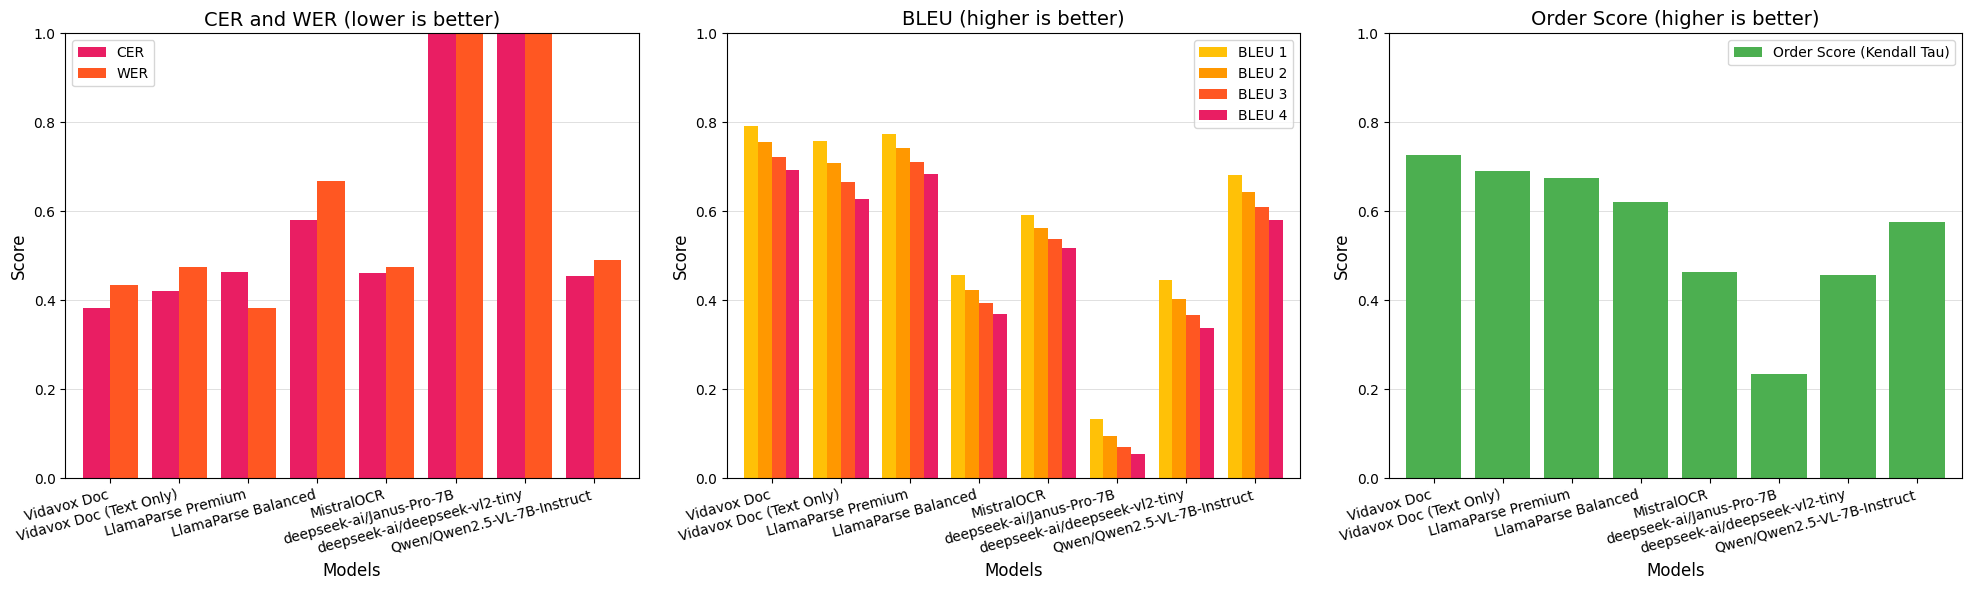

In [ ]:
# Filter for models shown in the image
# NOTE: Make sure the index names in df_new exactly match these strings
models_to_plot = ['Vidavox Doc', 'Vidavox Doc (Text Only)', 'LlamaParse Premium', 'LlamaParse Balanced', 'MistralOCR', 'deepseek-ai/Janus-Pro-7B', 'deepseek-ai/deepseek-vl2-tiny', 'Qwen/Qwen2.5-VL-7B-Instruct']
# Ensure only models present in the dataframe index are selected
models_available = [model for model in models_to_plot if model in df_new.index]
print(f"Models available for plotting: {models_available}")
df_plot = df_new.loc[models_available]

# --- FIX: Check if df_plot is empty before plotting ---
if df_plot.empty:
    print("No models to plot. 'df_plot' is empty.")
    print(f"Reason: None of the specified 'models_to_plot' were found in 'df_new.index'.")
    print(f"Models searched for: {models_to_plot}")
    print(f"Models found in df_new.index that matched: {models_available}")
    print(f"Index of df_new: {df_new.index.tolist()}")
else:
    print(f"Plotting data for the following models: {df_plot.index.tolist()}")
    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(20, 6)) # Increased width slightly for more models

    ax[0].set_title('CER and WER (lower is better)', fontsize=14)
    ax[1].set_title('BLEU (higher is better)', fontsize=14)
    ax[2].set_title('Order Score (higher is better)', fontsize=14)

    # --- Plotting CER and WER ---
    # Create a bar plot for CER and WER
    df_plot[['CER', 'WER']].plot(kind='bar', ax=ax[0], width=0.8, color=['#E91E63', '#FF5722']) # Pink/Red, Orange/Red

    # --- Plotting BLEU scores ---
    # Create a bar plot for BLEU scores
    df_plot[['BLEU 1', 'BLEU 2', 'BLEU 3', 'BLEU 4']].plot(kind='bar', ax=ax[1], width=0.8, color=['#FFC107', '#FF9800', '#FF5722', '#E91E63']) # Yellow/Orange, Orange/Red, Pink/Red

    # --- Plotting Order Score ---
    # Create a bar plot for Order Score
    df_plot[['Order Score (Kendall Tau)']].plot(kind='bar', ax=ax[2], width=0.8, color=['#4CAF50']) # Green

    # --- Customizing the plots ---
    # Set y-axis limits and ticks
    for i in range(3):
        ax[i].set_ylim(0, 1.0) # Set y-axis limits from 0 to exactly 1.0
        ax[i].yaxis.set_major_locator(mticker.MultipleLocator(0.2)) # Ticks every 0.2
        ax[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f')) # Format y-ticks to 1 decimal place

    # Set x-axis labels
    for i in range(3):
        ax[i].set_xticks(np.arange(len(df_plot.index)))
        ax[i].set_xticklabels(df_plot.index, rotation=15, ha='right', fontsize=10)
        ax[i].set_xlabel('Models', fontsize=12) # Combined x-axis label setting

    # Set y-axis labels
    for i in range(3):
        ax[i].set_ylabel('Score', fontsize=12)

    # Add gridlines
    for i in range(3):
        ax[i].yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgrey')
        ax[i].set_axisbelow(True) # Keep grid behind bars

    # Adjust layout and display
    # Using rect might be necessary if legends are clipped by tight_layout alone
    # For example: plt.tight_layout(rect=[0, 0, 0.85, 1]) to make space on the right
    plt.tight_layout()
    plt.show()

Plotting data for the following models: ['Vidavox Doc', 'Vidavox Doc (Text Only)', 'LlamaParse Premium', 'LlamaParse Balanced', 'MistralOCR', 'deepseek-ai/Janus-Pro-7B', 'deepseek-ai/deepseek-vl2-tiny', 'Qwen/Qwen2.5-VL-7B-Instruct']


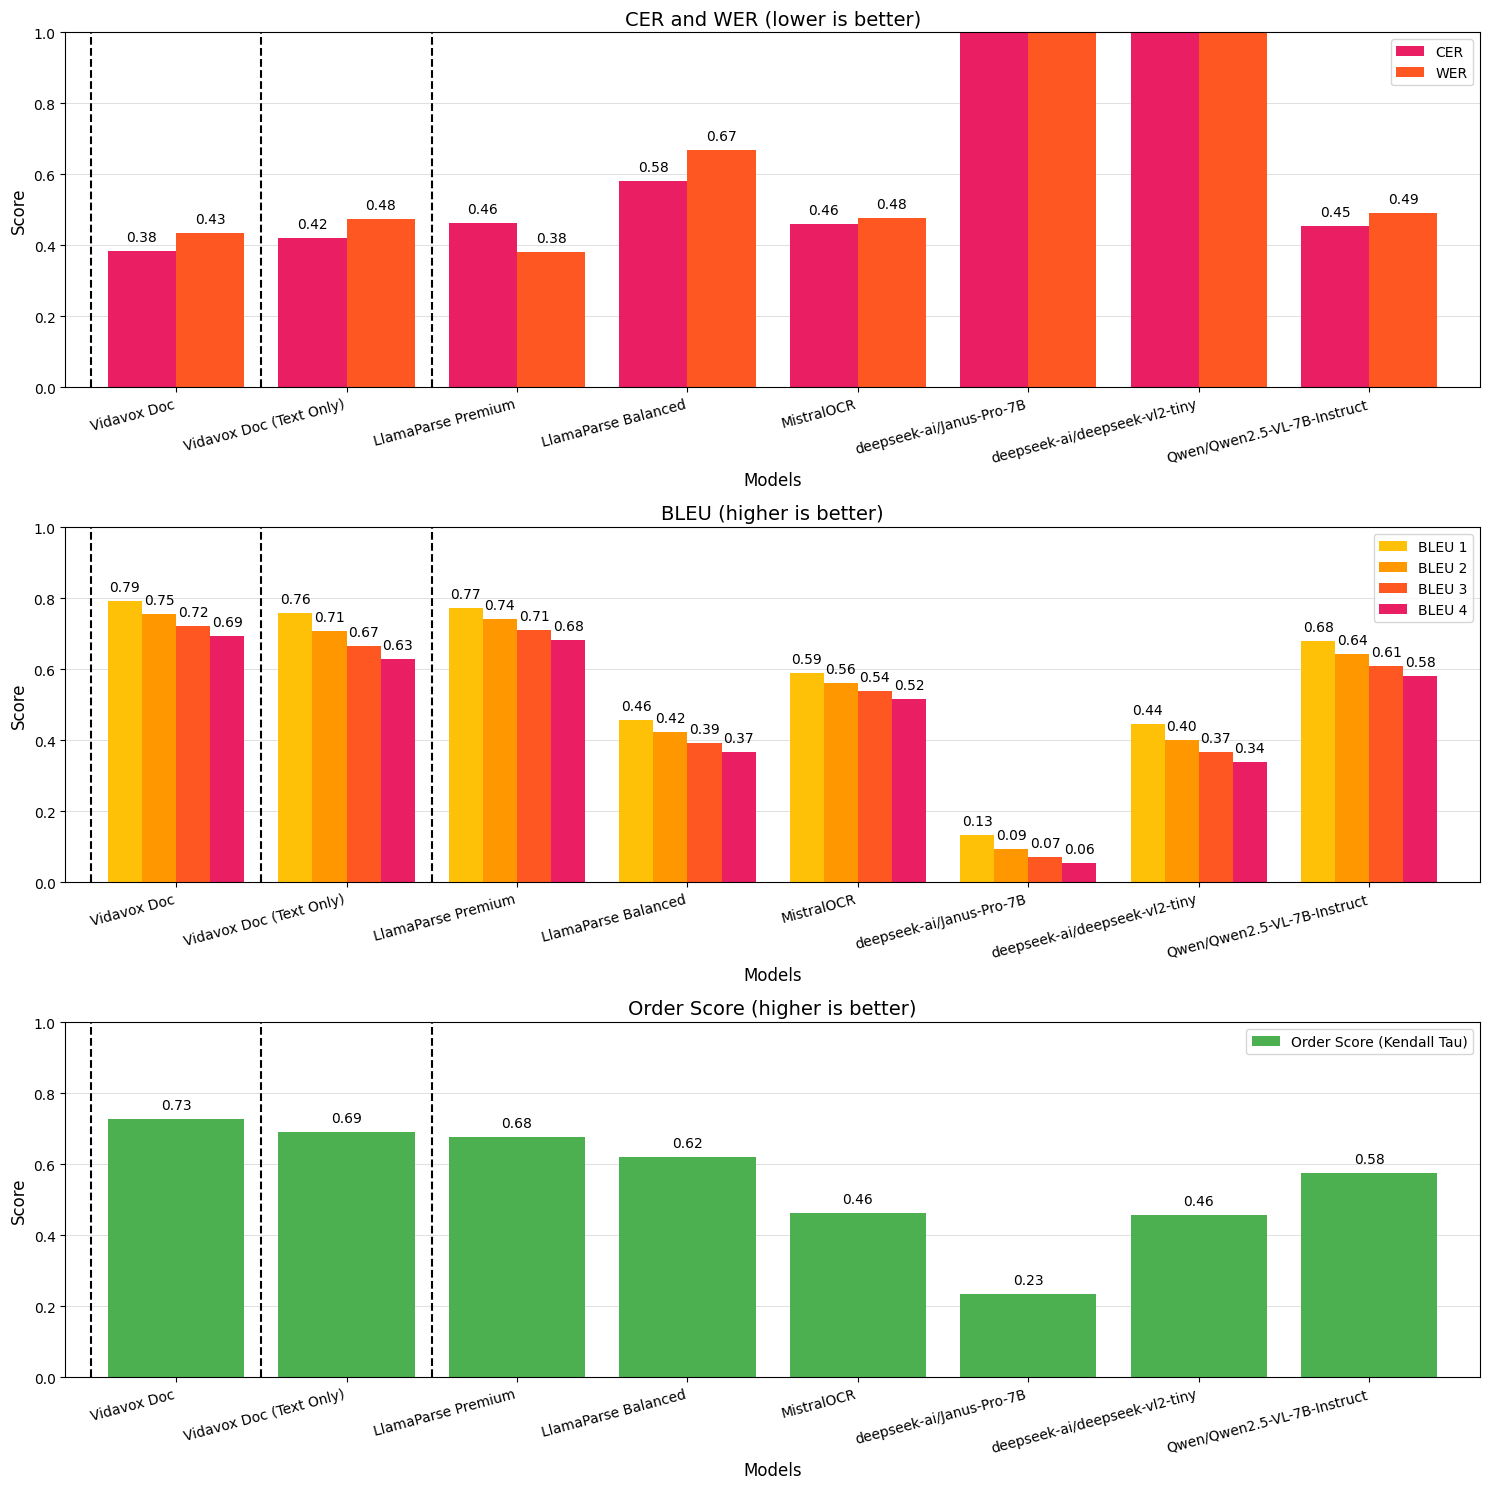

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

# --- Your original code starts here ---

# Filter for models shown in the image
# NOTE: Make sure the index names in df_new exactly match these strings
models_to_plot = ['Vidavox Doc', 'Vidavox Doc (Text Only)', 'LlamaParse Premium', 'LlamaParse Balanced', 'MistralOCR', 'deepseek-ai/Janus-Pro-7B', 'deepseek-ai/deepseek-vl2-tiny', 'Qwen/Qwen2.5-VL-7B-Instruct']

# Ensure only models present in the dataframe index are selected
models_available = [model for model in models_to_plot if model in df_new.index]

# Create df_plot. It might be empty if models_available is empty.
df_plot = df_new.loc[models_available]

# --- FIX: Check if df_plot is empty before plotting ---
if df_plot.empty:
    print("No models to plot. 'df_plot' is empty.")
    print(f"Reason: None of the specified 'models_to_plot' were found in 'df_new.index'.")
    print(f"Models searched for: {models_to_plot}")
    print(f"Models found in df_new.index that matched: {models_available}")
    print(f"Index of df_new: {df_new.index.tolist()}")
else:
    print(f"Plotting data for the following models: {df_plot.index.tolist()}")
    # Plotting
    fig, ax = plt.subplots(3, 1, figsize=(15, 15)) # Increased width slightly for more models

    ax[0].set_title('CER and WER (lower is better)', fontsize=14)
    ax[1].set_title('BLEU (higher is better)', fontsize=14)
    ax[2].set_title('Order Score (higher is better)', fontsize=14)

    # --- Plotting CER and WER ---
    # Create a bar plot for CER and WER
    df_plot[['CER', 'WER']].plot(kind='bar', ax=ax[0], width=0.8, color=['#E91E63', '#FF5722']) # Pink/Red, Orange/Red

    # --- Plotting BLEU scores ---
    # Create a bar plot for BLEU scores
    df_plot[['BLEU 1', 'BLEU 2', 'BLEU 3', 'BLEU 4']].plot(kind='bar', ax=ax[1], width=0.8, color=['#FFC107', '#FF9800', '#FF5722', '#E91E63']) # Yellow/Orange, Orange/Red, Pink/Red

    # --- Plotting Order Score ---
    # Create a bar plot for Order Score
    df_plot[['Order Score (Kendall Tau)']].plot(kind='bar', ax=ax[2], width=0.8, color=['#4CAF50']) # Green

    # --- Customizing the plots ---
    # Set y-axis limits and ticks
    for i in range(3):
        ax[i].set_ylim(0, 1.0) # Set y-axis limits from 0 to exactly 1.0
        ax[i].yaxis.set_major_locator(mticker.MultipleLocator(0.2)) # Ticks every 0.2
        ax[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f')) # Format y-ticks to 1 decimal place

    # Set x-axis labels
    for i in range(3):
        ax[i].set_xticks(np.arange(len(df_plot.index)))
        ax[i].set_xticklabels(df_plot.index, rotation=15, ha='right', fontsize=10)
        ax[i].set_xlabel('Models', fontsize=12) # Combined x-axis label setting

    # Set y-axis labels
    for i in range(3):
        ax[i].set_ylabel('Score', fontsize=12)

    # Add gridlines
    for i in range(3):
        ax[i].yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgrey')
        ax[i].set_axisbelow(True) # Keep grid behind bars

    # # Dashed Vertical Lines (Update to cover all gaps)
    for i in range(3):
        line_start_pos = df_plot.index.get_loc(df_plot.index[0]) - 0.5
        ax[i].axvline(line_start_pos, color='black', linestyle='--', linewidth=1.5, ymin=0.0, ymax=1.0)
        for j in range(1, 3):
            line_pos = (df_plot.index.get_loc(df_plot.index[j-1]) + df_plot.index.get_loc(df_plot.index[j])) / 2
            ax[i].axvline(line_pos, color='black', linestyle='--', linewidth=1.5, ymin=0.0, ymax=1.0)

    # # Add legend
    # for i in range(3):
    #     ax[i].legend(title='', loc='upper left', bbox_to_anchor=(1, 1), fontsize=9) # Move legend outside

    # --- Add Bar Value Labels ---
    for i in range(3):
        for p in ax[i].patches:
            ax[i].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

    # Adjust layout and display
    # Using rect might be necessary if legends are clipped by tight_layout alone
    # For example: plt.tight_layout(rect=[0, 0, 0.85, 1]) to make space on the right
    plt.tight_layout()
    plt.show()